# Úkol č. 4 - regrese (do 2. ledna)

  * Cílem tohoto úkolu je vyzkoušet si řešit regresní problém na reálných (ale celkem vyčištěných) datech.
  
> **Nejdůležitější na úkolu je to, abyste udělali vše procesně správně: korektní rozdělení datasetu, ladění hyperparametrů, vyhodnocení výsledků atp.**

## Dataset

  * Zdrojem dat je list *Data* v souboru `Residential-Building-Data-Set.xlsx` na course pages (originál zde: https://archive.ics.uci.edu/ml/datasets/Residential+Building+Data+Set#).
  * Popis datasetu najdete na listu *Descriptions* ve stejném souboru.
  

## Pokyny k vypracování

  1. Rozdělte data na trénovací a testovací množinu.
  1. Proveďte základní průzkum dat a příp. vyhoďte nezajímavé příznaky.
  1. Aplikujte lineární a hřebenovou regresi a výsledky řádně vyhodnoťte:
    * K měření chyby použijte `mean_absolute_error`.
    * Experimentujte s tvorbou nových příznaků (na základě těch dostupných).
    * Experimentujte se standardizací/normalizací dat.
    * Vyberte si hyperparametry modelů k ladění a najděte jejich nejlepší hodnoty.
  1. Použijte i jiný model než jen lineární a hřebenovou regresi.


## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte pouze tento Jupyter Notebook, opravujíví by neměl nic jiného potřebovat.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

In [325]:
# odtud už je to Vaše
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, LinearRegression, Lasso, RidgeCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
import statistics as stat
import seaborn as sns

In [326]:
df = pd.read_excel("data.xlsx")
df

,PROJECT DATES (PERSIAN CALENDAR),Unnamed: 1,Unnamed: 2,Unnamed: 3,PROJECT PHYSICAL AND FINANCIAL VARIABLES,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,ECONOMIC VARIABLES AND INDICES IN TIME LAG 1,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,ECONOMIC VARIABLES AND INDICES IN TIME LAG 2,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,ECONOMIC VARIABLES AND INDICES IN TIME LAG 3,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,ECONOMIC VARIABLES AND INDICES IN TIME LAG 4,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,ECONOMIC VARIABLES AND INDICES IN TIME LAG 5,Unnamed: 89,Unnamed: 90,Unnamed: 91,Unnamed: 92,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96,Unnamed: 97,Unnamed: 98,Unnamed: 99,Unnamed: 100,Unnamed: 101,Unnamed: 102,Unnamed: 103,Unnamed: 104,Unnamed: 105,Unnamed: 106,OUTPUTS,Unnamed: 108
0,START YEAR,START QUARTER,COMPLETION YEAR,COMPLETION QUARTER,V-1,V-2,V-3,V-4,V-5,V-6,V-7,V-8,V-11,V-12,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-25,V-26,V-27,V-28,V-29,V-11,V-12,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-25,V-26,V-27,V-28,V-29,V-11,V-12,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-25,V-26,V-27,V-28,V-29,V-11,V-12,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-25,V-26,V-27,V-28,V-29,V-11,V-12,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-25,V-26,V-27,V-28,V-29,V-9,V-10
1,81,1,85,1,1,3150,920,598.5,190,1010.84,16,1200,6713,56.2,61.52,6.11,320957,3485.8,64.5,239.5,12456.6,15,797.3,809.8,1755,8003,67.81,63.25,3758.77,42587,628133,4986,55.5,60.78,3.94,297210,3663.5,61.5,179.63,9342.45,15,757.8,861.8,1755,8018,65,60.53,3538.71,31940.2,610503,6788,54.2,59.4,5.41,280452,3755.8,58.1,119.75,6228.3,15,795,818.5,1755,8001,63.69,58.55,3347.72,21293.5,589390,5728,52.4,57.65,5.4,262789,2931.4,54.2,59.88,3114.15,15,746.8,815.5,1755,8013,62.78,56.45,3387.72,10646.8,606524,7196,51.3,56.13,5.97,249111,2562.3,52.8,217,10445.6,15,733.8,815.5,1755,8002,60.74,54.26,2978.26,41407,601988,2200,410
2,84,1,89,4,1,7600,1140,3040,400,963.81,23,2900,3152,106,103.03,3.15,685698,3526.1,105.5,208.8,17584.3,15,1408.4,1473.5,8842.18,8864,105.52,105.32,12113,45966,1.189e+06,2700,103,101.84,2.65,625829,4386.9,100.4,156.6,13188.2,15,1424.1,1584.3,8776.71,8799,101,101.89,13571.8,34474.5,1067772,3561,98.2,98.64,2.76,602225,3819,97.2,104.4,8792.15,15,1298.8,1389.6,8699.73,8735,98.12,98.45,13596.4,22983,973524,3157,92.8,96.49,3.05,552124,3896.7,96.9,52.2,4396.08,15,1294.2,1288,8555.54,8585,95.35,94.34,12063.5,11491.5,954629,3678,86.2,83.21,3.25,526596,2790.6,94.1,334.8,14488.6,15,1143.8,1316.3,8364.78,8393,90.95,89.79,11379.4,44835,929027,5000,1000
3,78,1,81,4,1,4800,840,480,100,689.84,15,630,1627,41,41.25,1.74,160402,1217.5,34.4,285.8,6489.1,15,614,608.2,1755,7773,45.91,38.34,1537.96,39066,524765,1580,40.3,40.84,1.15,150267,1149.5,34.1,214.35,4866.83,15,573.727,680.29,1755,6714,43.4,36.45,1535.16,29299.5,466212,2628,39.3,40.21,1.52,143738,1284.5,33.5,142.9,3244.55,15,554.082,663.97,1755,5827,41.79,34.76,1527.55,19533,409678,2374,38,39.43,0.92,134548,1191.1,33.7,71.45,1622.28,15,574.6,680.5,1755,5565,41.03,33.37,1601.79,9766.5,403875,2693,36.2,37.64,1.55,134312,1529,31.43,175.7,3994.7,15,589.5,765.8,1755,4930,38.7,32.04,1653.06,37933,377829,1200,170
4,72,2,73,2,1,685,202,13.7

In [327]:
df.columns = df.iloc[0]
df = df.drop(df.index[[0]])
cback = df.columns
df = df.astype(float)
df.columns = cback
pd.options.display.max_columns = None
df.describe() #je videt, ze data jsou celkem v prodaku, ale mame 5 time lagu pro ekonomicke promene

,START YEAR,START QUARTER,COMPLETION YEAR,COMPLETION QUARTER,V-1,V-2,V-3,V-4,V-5,V-6,V-7,V-8,V-11,V-12,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-25,V-26,V-27,V-28,V-29,V-11,V-12,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-25,V-26,V-27,V-28,V-29,V-11,V-12,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-25,V-26,V-27,V-28,V-29,V-11,V-12,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-25,V-26,V-27,V-28,V-29,V-11,V-12,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-25,V-26,V-27,V-28,V-29,V-9,V-10
count,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,3.720000e+02,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,3.720000e+02,372.000000,372.000000,372.000000,372.000000,3.720000e+02,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,3.720000e+02,372.000000,372.000000,372.000000,372.000000,3.720000e+02,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,3.720000e+02,372.000000,372.000000,372.00000,372.000000,3.720000e+02,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,3.720000e+02,372.000000,372.000000,372.000000,372.000000,3.720000e+02,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,3.720000e+02,372.000000,372.000000
mean,81.483871,2.190860,82.951613,2.586022,9.728495,1729.044355,426.114247,327.904086,163.118280,554.419839,6.266129,1088.118280,4210.998091,94.427957,88.050484,3.605323,6.411116e+05,4805.553495,98.677823,182.002124,18861.352796,14.069892,1327.458353,1466.269247,5934.194435,7805.037634,88.380134,87.073978,6604.944973,28296.934866,1.041556e+06,3990.014489,89.634409,84.383629,3.412769,6.002571e+05,4594.804301,92.148790,186.687876,18415.299301,14.180108,1249.017747,1385.723441,5723.675323,7713.588172,84.906102,83.434005,6462.124005,29169.714059,9.878810e+05,3885.660645,85.210215,81.180618,3.359973,5.631815e+05,4238.752957,86.491102,174.285780,16370.394677,14.263441,1188.981246,1314.671667,5589.884032,7623.298925,81.655027,79.712446,6349.516909,27456.405134,9.390451e+05,3865.851317,80.760484,78.06379,3.193118,5.253876e+05,3944.422849,81.535914,145.835188,13350.974973,14.314516,1140.085392,1245.397984,5522.351290,7537.037634,78.925349,76.317849,6131.099409,23469.629032,9.102971e+05,3757.436156,76.647312,74.524328,3.160108,4.938735e+05,3588.076882,76.562177,174.585457,15297.033522,14.454301,1081.951803,1187.484704,5403.213091,7431.560215,76.288817,73.446398,5915.576801,27551.883065,8.789713e+05,1387.432796,232.647849
std,4.182141,1.083382,4.223898,1.123442,6.563309,1802.371491,490.076498,563.544337,112.604343,275.105953,2.096495,995.826172,1776.645135,62.891433,49.364302,1.616244,5.421638e+05,3947.155806,73.015410,110.711378,21313.733301,1.526215,868.491300,957.244634,3543.375809,1987.196426,45.774134,51.733900,4244.446452,13870.611589,6.330130e+05,1623.468210,58.900266,46.907074,1.473947,5.103997e+05,3843.347388,66.322177,105.488736,20369.884598,1.417006,819.112881,887.128170,3575.052995,2049.682461,43.914286,49.532897,4289.692048,12200.639608,5.852443e+05,1576.339507,55.216053,44.804162,1.508873,4.802790e+05,3354.480333,60.883347,95.083233,17955.337955,1.346036,757.597756,824.268761,3571.239535,2109.050745,42.125358,47.138223,4359.169652,10986.630086,5.459285e+05,1617.762278,51.325779,42.53227,1.350130,4.494228e+05,2975.230431,55.812909,90.529284,16097.860403,1.292943,731.432289,766.884260,3549.686424,2152.969795,40.625726,45.086898,4302.542046,11736.682661,5.29829

In [328]:
X = df.iloc[:,:107] #zkusim poprve udelat regresi bez upravy dat
Y = df.iloc[:,107:]

In [329]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.25, random_state=39) 

In [330]:
print('Train X shape', xtrain.shape)
print('Test X shape', xtest.shape)

Train X shape (279, 107)
Test X shape (93, 107)


In [331]:
lr1 = LinearRegression() #poprve linearni
lr1.fit(xtrain, ytrain)
mean_absolute_error(lr1.predict(xtest), ytest)

58.04460672168797

In [332]:
#coz pro tolik priznaku a takovyhle veci, jako cena domu, asi neni tak spatne

In [333]:
rr1 = Ridge() #hrebenova
rr1.fit(xtrain, ytrain)
mean_absolute_error(rr1.predict(xtest), ytest)

57.979226779925284

In [334]:
#zlepseni neni silne

In [335]:
sgdr1 = RidgeCV() #hrebenova s cross validaci
sgdr1.fit(xtrain, ytrain)
mean_absolute_error(sgdr1.predict(xtest), ytest)

64.3995362838725

In [336]:
#ted'ka pokusim sjednotit priznaky pro ekonomicke priznaky pomoci medianu
economic_labels = X.iloc[:,12:31].columns.astype(list)
economic_labels
Xn = X.iloc[:,:12]
economic_labels = economic_labels.tolist() 
count = 0
for i in economic_labels:
    col = []
    for j in range(0, 372):
        ls = []
        for k in X[i].iloc[j]:
            ls.append(k)
        col.append(stat.median(ls))
    Xn.insert(count+12, i, col)
    count+=1
Xn

,START YEAR,START QUARTER,COMPLETION YEAR,COMPLETION QUARTER,V-1,V-2,V-3,V-4,V-5,V-6,V-7,V-8,V-11,V-12,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-25,V-26,V-27,V-28,V-29
1,81.0,1.0,85.0,1.0,1.0,3150.0,920.0,598.5,190.0,1010.84,16.0,1200.0,6713.00,54.2,59.40,5.41,280451.7,3485.8,58.10,179.63,9342.45,15.0,757.800000,815.50,1755.00,8003.0,63.69,58.55,3387.72,31940.25,606524.2
2,84.0,1.0,89.0,4.0,1.0,7600.0,1140.0,3040.0,400.0,963.81,23.0,2900.0,3157.00,98.2,98.64,3.05,602224.7,3819.0,97.20,156.60,13188.23,15.0,1298.800000,1389.60,8699.73,8735.0,98.12,98.45,12113.01,34474.50,973523.7
3,78.0,1.0,81.0,4.0,1.0,4800.0,840.0,480.0,100.0,689.84,15.0,630.0,2374.00,39.3,40.21,1.52,143737.7,1217.5,33.70,175.70,3994.70,15.0,574.600000,680.29,1755.00,5827.0,41.79,34.76,1537.96,29299.50,409677.9
4,72.0,2.0,73.0,2.0,1.0,685.0,202.0,13.7,20.0,459.54,4.0,140.0,2580.93,11.4,6.97,2.25,32793.7,322.5,11.73,28.30,305.20,12.0,180.371507,208.60,1450.47,1507.0,10.17,9.35,508.64,16388.00,123618.0
5,87.0,1.0,90.0,2.0,1.0,3000.0,800.0,1230.0,410.0,631.91,13.0,5000.0,6370.00,177.6,147.44,5.33,1451175.9,8245.0,188.90,294.98,52083.60,11.0,2451.200000,2627.50,9254.28,9347.0,140.90,146.20,9821.00,37179.00,1734973.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,83.0,4.0,86.0,1.0,20.0,1350.0,350.0,108.0,80.0,251.37,9.0,830.0,3157.00,92.8,96.49,2.76,552124.4,3819.0,96.90,156.60,10866.45,15.0,1294.200000,1316.30,8555.54,8585.0,95.35,94.34,12063.50,33626.25,954628.6
369,81.0,2.0,82.0,4.0,20.0,600.0,150.0,36.0,60.0,299.55,6.0,570.0,6713.00,55.5,60.78,5.41,297210.1,3663.5,61.50,119.75,6228.30,15.0,795.000000,818.50,1755.00,8003.0,65.00,60.53,3538.71,21293.50,610502.7
370,84.0,4.0,86.0,3.0,20.0,1900.0,430.0,285.0,150.0,364.41,7.0,640.0,2859.00,111.4,104.33,2.50,704586.3,4858.1,107.50,156.60,17584.30,15.0,1534.600000,1795.30,8920.04,8938.0,109.02,108.51,12113.01,34474.50,1181572.6
371,82.0,3.0,84.0,4.0,20.0,510.0,160.0,30.6,60.0,245.28,9.0,790.0,3255.00,69.4,76.29,2.84,417524.0,4730.8,81.70,186.00,7874.40,14.0,1005.000000,1104.70,8002.21,8058.0,79.65,76.92,5096.97,22417.50,788018.3


In [337]:
xtrain, xtest, ytrain, ytest = train_test_split(Xn, Y, test_size=0.25, random_state=39) 

In [338]:
print('Train X shape', xtrain.shape)
print('Test X shape', xtest.shape)

Train X shape (279, 31)
Test X shape (93, 31)


In [339]:
lr1 = LinearRegression() #poprve linearni
lr1.fit(xtrain, ytrain)
mean_absolute_error(lr1.predict(xtest), ytest)

59.548123556283784

In [340]:
rr1 = Ridge() #hrebenova
rr1.fit(xtrain, ytrain)
mean_absolute_error(rr1.predict(xtest), ytest)

59.42042087494754

In [341]:
sgdr1 = RidgeCV() #hrebenova s cross validaci
sgdr1.fit(xtrain, ytrain)
mean_absolute_error(sgdr1.predict(xtest), ytest)

59.72936643426851

In [342]:
#udelalo to horsi, takze tyhle przinaky zustavime

In [343]:
#co pokud pridame ty median sloupce jako nove priznaky?

In [344]:
economic_labels = X.iloc[:,12:31].columns.astype(list)
economic_labels
economic_labels = economic_labels.tolist() 
count = 0
med = pd.DataFrame()
for i in economic_labels:
    col = []
    for j in range(0, 372):
        ls = []
        for k in X[i].iloc[j]:
            ls.append(k)
        col.append(stat.median(ls))
    X.insert(count+12, i+"m", col)
    med.insert(count, i, col)
    count+=1
X

,START YEAR,START QUARTER,COMPLETION YEAR,COMPLETION QUARTER,V-1,V-2,V-3,V-4,V-5,V-6,V-7,V-8,V-11m,V-12m,V-13m,V-14m,V-15m,V-16m,V-17m,V-18m,V-19m,V-20m,V-21m,V-22m,V-23m,V-24m,V-25m,V-26m,V-27m,V-28m,V-29m,V-11,V-12,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-25,V-26,V-27,V-28,V-29,V-11,V-12,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-25,V-26,V-27,V-28,V-29,V-11,V-12,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-25,V-26,V-27,V-28,V-29,V-11,V-12,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-25,V-26,V-27,V-28,V-29,V-11,V-12,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-25,V-26,V-27,V-28,V-29
1,81.0,1.0,85.0,1.0,1.0,3150.0,920.0,598.5,190.0,1010.84,16.0,1200.0,6713.00,54.2,59.40,5.41,280451.7,3485.8,58.10,179.63,9342.45,15.0,757.800000,815.50,1755.00,8003.0,63.69,58.55,3387.72,31940.25,606524.2,6713.00,56.2,61.52,6.11,320957.30,3485.8,64.5,239.50,12456.60,15.0,797.3,809.8,1755.00,8003.0,67.81,63.25,3758.77,42587.00,628132.9,4986.0,55.5,60.78,3.94,297210.1,3663.5,61.50,179.63,9342.45,15.0,757.800000,861.80,1755.00,8018.0,65.00,60.53,3538.71,31940.25,610502.7,6788.0,54.2,59.40,5.41,280451.7,3755.8,58.10,119.75,6228.30,15.0,795.000000,818.50,1755.00,8001.0,63.69,58.55,3347.72,21293.50,589389.6,5728.0,52.4,57.65,5.40,262789.00,2931.4,54.20,59.88,3114.15,15.0,746.800000,815.50,1755.00,8013.0,62.78,56.45,3387.72,10646.75,606524.2,7196.0,51.3,56.13,5.97,249110.70,2562.3,52.80,217.00,10445.60,15.0,733.800000,815.50,1755.00,8002.0,60.74,54.26,2978.26,41407.00,601988.1
2,84.0,1.0,89.0,4.0,1.0,7600.0,1140.0,3040.0,400.0,963.81,23.0,2900.0,3157.00,98.2,98.64,3.05,602224.7,3819.0,97.20,156.60,13188.23,15.0,1298.800000,1389.60,8699.73,8735.0,98.12,98.45,12113.01,34474.50,973523.7,3152.00,106.0,103.03,3.15,685697.50,3526.1,105.5,208.80,17584.30,15.0,1408.4,1473.5,8842.18,8864.0,105.52,105.32,12113.01,45966.00,1188995.8,2700.0,103.0,101.84,2.65,625829.2,4386.9,100.40,156.60,13188.23,15.0,1424.100000,1584.30,8776.71,8799.0,101.00,101.89,13571.80,34474.50,1067772.0,3561.0,98.2,98.64,2.76,602224.7,3819.0,97.20,104.40,8792.15,15.0,1298.800000,1389.60,8699.73,8735.0,98.12,98.45,13596.37,22983.00,973523.7,3157.0,92.8,96.49,3.05,552124.40,3896.7,96.90,52.20,4396.08,15.0,1294.200000,1288.00,8555.54,8585.0,95.35,94.34,12063.50,11491.50,954628.6,3678.0,86.2,83.21,3.25,526596.40,2790.6,94.10,334.80,14488.60,15.0,1143.800000,1316.30,8364.78,8393.0,90.95,89.79,11379.37,44835.00,929027.1
3,78.0,1.0,81.0,4.0,1.0,4800.0,840.0,480.0,100.0,689.84,15.0,630.0,2374.00,39.3,40.21,1.52,143737.7,1217.5,33.70,175.70,3994.70,15.0,574.600000,680.29,1755.00,5827.0,41.79,34.76,1537.96,29299.50,409677.9,1627.00,41.0,41.25,1.74,160401.50,1217.5,34.4,285.80,6489.10,15.0,614.0,608.2,1755.00,7773.0,45.91,38.34,1537.96,39066.00,524764.8,1580.0,40.3,40.84,1.15,150266.8,1149.5,34.10,214.35,4866.83,15.0,573.726531,680.29,1755.00,6714.0,43.40,36.45,1535.16,29299.50,466212.2,2628.0,39.3,40.21,1.52,143737.7,1284.5,33.50,142.90,3244.55,15.0,554.081966,663.97,1755.00,5827.0,41.79,34.76,1527.55,19533.00,409677.9,2374.0,38.0,39.43,0.92,134548.40,1191.1,33.70,71.45,1622.28,15.0,574.600000,680.50,1755.00,5565.0,41.03,33.37,1601.79,9766.50,403875.0,2693.0,36.2,37.64,1.55,134312.50,1529.0,31.43,175.70,3994.70,15.0,589.500000,765.80,1755.00,4930.0,38.70,32.04,1653.06,37933.00,377828.6
4,72.0,2.0,73.0,2.0,1.0,685.0,202.0,13.7,20.0,459.54,4.0,140.0,2580.93,11.4,6.97,2.25,32793.7,322.5,11.73,28.30,305.20,12.0,180.371507,208.60,1450.47,1507.0,10.17,9.35,508.64,16388.00,123618.0,2580.93,12.1,10.03,1.24,38193.64,287.2,13.6,17.03,154.40,12.0,183.6,211.1,1612.95,1649.0,11.62,10.06,392.96,8435.75,141542.6,2952.0,11.6,8.50,1.99,35859.4,322.5,12.67,56.60,610.40,12.0,165.100000,208.60,1504.36,1582.0,10.86,9.79,435.10,32776.00,129102.4,2649.0,11.4,6.97,2.25,32793.7,388.9,11.73,42.45,457.80,12.0,167.900000,209.60,1450.47,1507.0,10.17,9.35,508.64,24582.00,123618.0,2312.0,10.6,5.44,2.58,30012.46,345.3,10.79,28.30,305.20,12.0,1

In [345]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.25, random_state=39) 

In [346]:
lr1 = LinearRegression() #poprve linearni
lr1.fit(xtrain, ytrain)
mean_absolute_error(lr1.predict(xtest), ytest)

58.82604482370641

In [347]:
rr1 = Ridge() #hrebenova
rr1.fit(xtrain, ytrain)
mean_absolute_error(rr1.predict(xtest), ytest)

58.794964106965885

In [348]:
med.insert(2, "V-9", Y.iloc[:,0])
med.insert(3, "V-10", Y.iloc[:,1])

In [349]:
#udelalo to horsi

In [350]:
corr = med.corr()

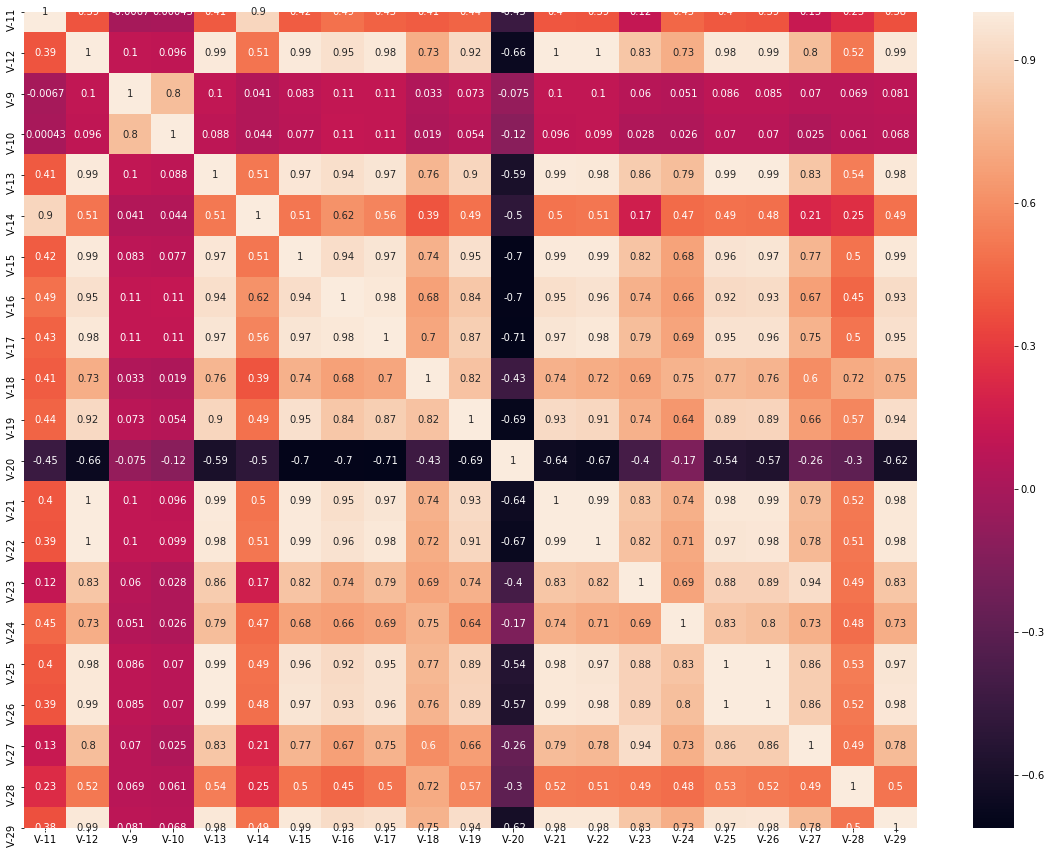

In [351]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.subplots(figsize=(20,15))
sns.heatmap(corr, annot=True) #tim padem muzeme vyhodit V-21 A V-25 priznaky

In [352]:
#v popisu jsem nasel jeste par priznaku, ze kterych "mozna": se da udelat nove("mozna protoze nejsem odbornik-ekonom (:  
#jsou to: v-19 a v-18; v22-v21; v-8 a v-1; v-3 a v-1
#v-4, v-5 a v-6
Xn = X.copy()
v65 = X['V-6']*X['V-5']*X['V-4'] #nasobeni jak jsem vsiml korelujicih priznaku dava tady 0.9 presnosti
v81 = X['V-8']/X['V-1'] #zavislost ceny jednoho m^2 plochy domu od lokality
v31 = X['V-3']/X['V-1'] #zavislost ceny jednoho m^2 plochy pod dum od lokality
#v1918 = X['V-19']/X['V-18']
#v2221 = X['V-22']/X['V-21']
#X.insert(17, "V-19/V-18", v1918)
#X.insert(20, "V-22/V-21", v2221)
Xn.insert(10, "V-6/V-5", v65)
Xn.insert(13, "V-8/V-1", v81)
Xn.insert(9, "V-3/V-1", v31)
Xn = Xn.drop(columns = ["V-25", "V-12", "V-25m", "V-12m", "V-11"])
Xn

,START YEAR,START QUARTER,COMPLETION YEAR,COMPLETION QUARTER,V-1,V-2,V-3,V-4,V-5,V-3/V-1,V-6,V-6/V-5,V-7,V-8,V-8/V-1,V-11m,V-13m,V-14m,V-15m,V-16m,V-17m,V-18m,V-19m,V-20m,V-21m,V-22m,V-23m,V-24m,V-26m,V-27m,V-28m,V-29m,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-26,V-27,V-28,V-29,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-26,V-27,V-28,V-29,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-26,V-27,V-28,V-29,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-26,V-27,V-28,V-29,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-26,V-27,V-28,V-29
1,81.0,1.0,85.0,1.0,1.0,3150.0,920.0,598.5,190.0,920.0,1010.84,1.149477e+08,16.0,1200.0,1200.0,6713.00,59.40,5.41,280451.7,3485.8,58.10,179.63,9342.45,15.0,757.800000,815.50,1755.00,8003.0,58.55,3387.72,31940.25,606524.2,61.52,6.11,320957.30,3485.8,64.5,239.50,12456.60,15.0,797.3,809.8,1755.00,8003.0,63.25,3758.77,42587.00,628132.9,60.78,3.94,297210.1,3663.5,61.50,179.63,9342.45,15.0,757.800000,861.80,1755.00,8018.0,60.53,3538.71,31940.25,610502.7,59.40,5.41,280451.7,3755.8,58.10,119.75,6228.30,15.0,795.000000,818.50,1755.00,8001.0,58.55,3347.72,21293.50,589389.6,57.65,5.40,262789.00,2931.4,54.20,59.88,3114.15,15.0,746.800000,815.50,1755.00,8013.0,56.45,3387.72,10646.75,606524.2,56.13,5.97,249110.70,2562.3,52.80,217.00,10445.60,15.0,733.800000,815.50,1755.00,8002.0,54.26,2978.26,41407.00,601988.1
2,84.0,1.0,89.0,4.0,1.0,7600.0,1140.0,3040.0,400.0,1140.0,963.81,1.171993e+09,23.0,2900.0,2900.0,3157.00,98.64,3.05,602224.7,3819.0,97.20,156.60,13188.23,15.0,1298.800000,1389.60,8699.73,8735.0,98.45,12113.01,34474.50,973523.7,103.03,3.15,685697.50,3526.1,105.5,208.80,17584.30,15.0,1408.4,1473.5,8842.18,8864.0,105.32,12113.01,45966.00,1188995.8,101.84,2.65,625829.2,4386.9,100.40,156.60,13188.23,15.0,1424.100000,1584.30,8776.71,8799.0,101.89,13571.80,34474.50,1067772.0,98.64,2.76,602224.7,3819.0,97.20,104.40,8792.15,15.0,1298.800000,1389.60,8699.73,8735.0,98.45,13596.37,22983.00,973523.7,96.49,3.05,552124.40,3896.7,96.90,52.20,4396.08,15.0,1294.200000,1288.00,8555.54,8585.0,94.34,12063.50,11491.50,954628.6,83.21,3.25,526596.40,2790.6,94.10,334.80,14488.60,15.0,1143.800000,1316.30,8364.78,8393.0,89.79,11379.37,44835.00,929027.1
3,78.0,1.0,81.0,4.0,1.0,4800.0,840.0,480.0,100.0,840.0,689.84,3.311232e+07,15.0,630.0,630.0,2374.00,40.21,1.52,143737.7,1217.5,33.70,175.70,3994.70,15.0,574.600000,680.29,1755.00,5827.0,34.76,1537.96,29299.50,409677.9,41.25,1.74,160401.50,1217.5,34.4,285.80,6489.10,15.0,614.0,608.2,1755.00,7773.0,38.34,1537.96,39066.00,524764.8,40.84,1.15,150266.8,1149.5,34.10,214.35,4866.83,15.0,573.726531,680.29,1755.00,6714.0,36.45,1535.16,29299.50,466212.2,40.21,1.52,143737.7,1284.5,33.50,142.90,3244.55,15.0,554.081966,663.97,1755.00,5827.0,34.76,1527.55,19533.00,409677.9,39.43,0.92,134548.40,1191.1,33.70,71.45,1622.28,15.0,574.600000,680.50,1755.00,5565.0,33.37,1601.79,9766.50,403875.0,37.64,1.55,134312.50,1529.0,31.43,175.70,3994.70,15.0,589.500000,765.80,1755.00,4930.0,32.04,1653.06,37933.00,377828.6
4,72.0,2.0,73.0,2.0,1.0,685.0,202.0,13.7,20.0,202.0,459.54,1.259140e+05,4.0,140.0,140.0,2580.93,6.97,2.25,32793.7,322.5,11.73,28.30,305.20,12.0,180.371507,208.60,1450.47,1507.0,9.35,508.64,16388.00,123618.0,10.03,1.24,38193.64,287.2,13.6,17.03,154.40,12.0,183.6,211.1,1612.95,1649.0,10.06,392.96,8435.75,141542.6,8.50,1.99,35859.4,322.5,12.67,56.60,610.40,12.0,165.100000,208.60,1504.36,1582.0,9.79,435.10,32776.00,129102.4,6.97,2.25,32793.7,388.9,11.73,42.45,457.80,12.0,167.900000,209.60,1450.47,1507.0,9.35,508.64,24582.00,123618.0,5.44,2.58,30012.46,345.3,10.79,28.30,305.20,12.0,180.371507,158.45,1439.00,1450.0,8.85,590.64,16388.00,121857.2,3.91,3.00,27231.21,316.5,9.85,14.15,152.60,12.0,197.679557,152.25,1442.31,1456.0,8.34,686.16,8194.00,122031.7
5,87.0,1.0,90.0,2.0,1.0,3000.0,800.0,1230.0,410.0,800.0,631.91,3.186722e+08,13.0,5000.0,5000.0,6370.00,147.44,5.33,1451175.9,8245.0,188.90,294.98,52083.60,11.0,2451.200000,2627

In [353]:
xtrain, xtest, ytrain, ytest = train_test_split(Xn, Y, test_size=0.25, random_state=39) 

In [354]:
lr1 = LinearRegression() #poprve linearni
lr1.fit(xtrain, ytrain)
mean_absolute_error(lr1.predict(xtest), ytest) #ztrata se stala protoze delenim priznaku jsem dodal nelinearitu

64.25710430752142

In [355]:
rr1 = Ridge() #hrebenova
rr1.fit(xtrain, ytrain)
mean_absolute_error(rr1.predict(xtest), ytest) 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.12043e-20): result may not be accurate.
  overwrite_a=True).T


64.2137947929338

In [356]:
X

,START YEAR,START QUARTER,COMPLETION YEAR,COMPLETION QUARTER,V-1,V-2,V-3,V-4,V-5,V-6,V-7,V-8,V-11m,V-12m,V-13m,V-14m,V-15m,V-16m,V-17m,V-18m,V-19m,V-20m,V-21m,V-22m,V-23m,V-24m,V-25m,V-26m,V-27m,V-28m,V-29m,V-11,V-12,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-25,V-26,V-27,V-28,V-29,V-11,V-12,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-25,V-26,V-27,V-28,V-29,V-11,V-12,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-25,V-26,V-27,V-28,V-29,V-11,V-12,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-25,V-26,V-27,V-28,V-29,V-11,V-12,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-25,V-26,V-27,V-28,V-29
1,81.0,1.0,85.0,1.0,1.0,3150.0,920.0,598.5,190.0,1010.84,16.0,1200.0,6713.00,54.2,59.40,5.41,280451.7,3485.8,58.10,179.63,9342.45,15.0,757.800000,815.50,1755.00,8003.0,63.69,58.55,3387.72,31940.25,606524.2,6713.00,56.2,61.52,6.11,320957.30,3485.8,64.5,239.50,12456.60,15.0,797.3,809.8,1755.00,8003.0,67.81,63.25,3758.77,42587.00,628132.9,4986.0,55.5,60.78,3.94,297210.1,3663.5,61.50,179.63,9342.45,15.0,757.800000,861.80,1755.00,8018.0,65.00,60.53,3538.71,31940.25,610502.7,6788.0,54.2,59.40,5.41,280451.7,3755.8,58.10,119.75,6228.30,15.0,795.000000,818.50,1755.00,8001.0,63.69,58.55,3347.72,21293.50,589389.6,5728.0,52.4,57.65,5.40,262789.00,2931.4,54.20,59.88,3114.15,15.0,746.800000,815.50,1755.00,8013.0,62.78,56.45,3387.72,10646.75,606524.2,7196.0,51.3,56.13,5.97,249110.70,2562.3,52.80,217.00,10445.60,15.0,733.800000,815.50,1755.00,8002.0,60.74,54.26,2978.26,41407.00,601988.1
2,84.0,1.0,89.0,4.0,1.0,7600.0,1140.0,3040.0,400.0,963.81,23.0,2900.0,3157.00,98.2,98.64,3.05,602224.7,3819.0,97.20,156.60,13188.23,15.0,1298.800000,1389.60,8699.73,8735.0,98.12,98.45,12113.01,34474.50,973523.7,3152.00,106.0,103.03,3.15,685697.50,3526.1,105.5,208.80,17584.30,15.0,1408.4,1473.5,8842.18,8864.0,105.52,105.32,12113.01,45966.00,1188995.8,2700.0,103.0,101.84,2.65,625829.2,4386.9,100.40,156.60,13188.23,15.0,1424.100000,1584.30,8776.71,8799.0,101.00,101.89,13571.80,34474.50,1067772.0,3561.0,98.2,98.64,2.76,602224.7,3819.0,97.20,104.40,8792.15,15.0,1298.800000,1389.60,8699.73,8735.0,98.12,98.45,13596.37,22983.00,973523.7,3157.0,92.8,96.49,3.05,552124.40,3896.7,96.90,52.20,4396.08,15.0,1294.200000,1288.00,8555.54,8585.0,95.35,94.34,12063.50,11491.50,954628.6,3678.0,86.2,83.21,3.25,526596.40,2790.6,94.10,334.80,14488.60,15.0,1143.800000,1316.30,8364.78,8393.0,90.95,89.79,11379.37,44835.00,929027.1
3,78.0,1.0,81.0,4.0,1.0,4800.0,840.0,480.0,100.0,689.84,15.0,630.0,2374.00,39.3,40.21,1.52,143737.7,1217.5,33.70,175.70,3994.70,15.0,574.600000,680.29,1755.00,5827.0,41.79,34.76,1537.96,29299.50,409677.9,1627.00,41.0,41.25,1.74,160401.50,1217.5,34.4,285.80,6489.10,15.0,614.0,608.2,1755.00,7773.0,45.91,38.34,1537.96,39066.00,524764.8,1580.0,40.3,40.84,1.15,150266.8,1149.5,34.10,214.35,4866.83,15.0,573.726531,680.29,1755.00,6714.0,43.40,36.45,1535.16,29299.50,466212.2,2628.0,39.3,40.21,1.52,143737.7,1284.5,33.50,142.90,3244.55,15.0,554.081966,663.97,1755.00,5827.0,41.79,34.76,1527.55,19533.00,409677.9,2374.0,38.0,39.43,0.92,134548.40,1191.1,33.70,71.45,1622.28,15.0,574.600000,680.50,1755.00,5565.0,41.03,33.37,1601.79,9766.50,403875.0,2693.0,36.2,37.64,1.55,134312.50,1529.0,31.43,175.70,3994.70,15.0,589.500000,765.80,1755.00,4930.0,38.70,32.04,1653.06,37933.00,377828.6
4,72.0,2.0,73.0,2.0,1.0,685.0,202.0,13.7,20.0,459.54,4.0,140.0,2580.93,11.4,6.97,2.25,32793.7,322.5,11.73,28.30,305.20,12.0,180.371507,208.60,1450.47,1507.0,10.17,9.35,508.64,16388.00,123618.0,2580.93,12.1,10.03,1.24,38193.64,287.2,13.6,17.03,154.40,12.0,183.6,211.1,1612.95,1649.0,11.62,10.06,392.96,8435.75,141542.6,2952.0,11.6,8.50,1.99,35859.4,322.5,12.67,56.60,610.40,12.0,165.100000,208.60,1504.36,1582.0,10.86,9.79,435.10,32776.00,129102.4,2649.0,11.4,6.97,2.25,32793.7,388.9,11.73,42.45,457.80,12.0,167.900000,209.60,1450.47,1507.0,10.17,9.35,508.64,24582.00,123618.0,2312.0,10.6,5.44,2.58,30012.46,345.3,10.79,28.30,305.20,12.0,1

In [357]:
sc = StandardScaler() #zksuim normalizace

In [358]:
Xnn = sc.fit_transform(Xn) 

In [359]:
xtrain, xtest, ytrain, ytest = train_test_split(Xnn, Y, test_size=0.25, random_state=39) 

In [360]:
lr1 = LinearRegression() #poprve linearni
lr1.fit(xtrain, ytrain)
mean_absolute_error(lr1.predict(xtest), ytest) #ztrata se stala protoze delenim priznaku jsem dodal nelinearitu

48403084645.002045

In [361]:
rr1 = Ridge() #hrebenova
rr1.fit(xtrain, ytrain)
mean_absolute_error(rr1.predict(xtest), ytest) 

56.95301386656446

In [362]:
sc = MinMaxScaler() 

In [363]:
Xnn = sc.fit_transform(Xn)
xtrain, xtest, ytrain, ytest = train_test_split(Xnn, Y, test_size=0.25, random_state=39) 

In [364]:
lr1 = LinearRegression() #poprve linearni
lr1.fit(xtrain, ytrain)
mean_absolute_error(lr1.predict(xtest), ytest) #ztrata se stala protoze delenim priznaku jsem dodal nelinearitu

298962991214.1899

In [365]:
rr1 = Ridge() #hrebenova
rr1.fit(xtrain, ytrain)
mean_absolute_error(rr1.predict(xtest), ytest) 

103.58607086220348

In [366]:
sc = MaxAbsScaler()

In [367]:
Xnn = sc.fit_transform(Xn)
xtrain, xtest, ytrain, ytest = train_test_split(Xnn, Y, test_size=0.25, random_state=39) 

In [368]:
lr1 = LinearRegression() #poprve linearni
lr1.fit(xtrain, ytrain)
mean_absolute_error(lr1.predict(xtest), ytest) #ztrata se stala protoze delenim priznaku jsem dodal nelinearitu

6546996087.253024

In [369]:
rr1 = Ridge() #hrebenova
rr1.fit(xtrain, ytrain)
mean_absolute_error(rr1.predict(xtest), ytest) 

103.07979174663859

In [370]:
sc = RobustScaler()
Xnn = sc.fit_transform(Xn)
xtrain, xtest, ytrain, ytest = train_test_split(Xnn, Y, test_size=0.25, random_state=39) 

In [371]:
lr1 = LinearRegression() #poprve linearni
lr1.fit(xtrain, ytrain)
mean_absolute_error(lr1.predict(xtest), ytest) #ztrata se stala protoze delenim priznaku jsem dodal nelinearitu

10663940897.522503

In [372]:
rr1 = Ridge() #hrebenova
rr1.fit(xtrain, ytrain)
mean_absolute_error(rr1.predict(xtest), ytest) 

56.84377476376624

In [373]:
#vyslo mi, ze standartizace dela horsi
#zkusim jeste normalizace jako parametr regresse
xtrain, xtest, ytrain, ytest = train_test_split(Xn, Y, test_size=0.25, random_state=39) 
lr1 = LinearRegression(normalize = True) #poprve linearni
lr1.fit(xtrain, ytrain)
mean_absolute_error(lr1.predict(xtest), ytest) #ztrata se stala protoze delenim priznaku jsem dodal nelinearitu

441788502.31410134

In [374]:
rr1 = Ridge(normalize = True) #hrebenova
rr1.fit(xtrain, ytrain)
mean_absolute_error(rr1.predict(xtest), ytest) 

171.02315960255302

In [375]:
#takze nejlepsi vysledek je hrebenova regresse s RobustSclaler'em

In [380]:
#najdu hyperparametry pro hrebenovou regresse
sc = RobustScaler()
Xnn = sc.fit_transform(Xn)
xtrain, xtest, ytrain, ytest = train_test_split(Xnn, Y, test_size=0.25, random_state=39) 
ridge_alpha = [0,1,2,5,7,10,25,50,100, 200, 230, 250,265, 270, 275, 290, 300, 500]
for i in ridge_alpha:
    rr = Ridge(alpha = i)
    rr.fit(xtrain, ytrain)
    print(mean_absolute_error(rr.predict(xtest), ytest) )

25026961502416.07
56.84377476376624
57.02494339401628
59.87499860690609
63.72492138029686
69.61314984044884
91.99769836407731
115.7694899541816
139.19476284240272
158.82294981365465
162.03802280039577
163.8226269855753
165.01722448551448
165.38933082513623
165.7519717807557
166.78471251218332
167.43508595902998
175.99701385972836


In [382]:
#nejlepsi je alpha = 1

In [389]:
#zkusim udelat regresse pres Lasso
lasso_alpha = [0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.2,1.4,1.8,2]
for i in lasso_alpha:
    lasso = Lasso(alpha = i)
    lasso.fit(xtrain, ytrain)
    print(mean_absolute_error(lasso.predict(xtest), ytest) )

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1053502.2561710528, tolerance: 39445.313996415774
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38168.89420313286, tolerance: 721.8924193548388
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1213205.906280044, tolerance: 39445.313996415774
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

58.821747751879855
57.75841223822543
57.42801973874774
56.747079985360244
56.208314738179766
55.86727357355454
55.60825895495951
55.24841974893493
55.10399767432761
54.977853948847276
54.84386523387518
54.97719030172563
55.217993431362885
55.79676531655911
55.95882497090117


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 594387.1743404749, tolerance: 39445.313996415774
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 506875.5942787649, tolerance: 39445.313996415774
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 612151.9275698857, tolerance: 39445.313996415774
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

In [391]:
#takze nejelepsi model ze 3 pouzitych je Lasso s alpha = 1

In [392]:
lasso = Lasso(alpha = 1)
lasso.fit(xtrain, ytrain)
print(mean_absolute_error(lasso.predict(xtest), ytest) )

54.84386523387518


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 411091.45486018993, tolerance: 39445.313996415774
  positive)
